In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.model_selection import train_test_split

In [2]:
#define predictor columns and target column
predictor_columns = ['zq5', 'zq10', 'zq15', 'zq20', 'zq25', 'zq30', 'zq35', 'zq40', 'zq45', 'zq50', 'zq55', 'zq60',
                     'zq65', 'zq70', 'zq75', 'zq80', 'zq85', 'zq90', 'zq95', 'pzabovezmean', 'pzabove2',
                     'zpcum1', 'zpcum2', 'zpcum3', 'zpcum4', 'zpcum5', 'zpcum6', 'zpcum7', 'zpcum8', 'zpcum9']

target_column = 'D_AVERAGE'

data_sweden = pd.read_csv('Image_data\merged_data_permanent_cleaned.csv', index_col = [0])

#rename 'Hgv' to 'H_AVERAGE'
data_sweden = data_sweden.rename(columns = {"Dgv": "D_AVERAGE"})

#for training and testing on Sweden only
data_train_sweden_1 = data_sweden[data_sweden['area_code'] == 1]
data_train_sweden_2 = data_sweden[data_sweden['area_code'] == 2]
data_train_sweden_3 = data_sweden[data_sweden['area_code'] == 3]
data_train_sweden_4 = data_sweden[data_sweden['area_code'] == 4]

#data_train_sweden_234 = data_train_sweden_4
data_train_sweden_234 = pd.concat([data_train_sweden_2, data_train_sweden_3])
data_train_sweden_234 = pd.concat([data_train_sweden_234, data_train_sweden_4])
data_train_sweden_1, data_test_sweden_1 = train_test_split(data_train_sweden_1, test_size = 0.4, random_state = 8)
data_train_sweden_234

#evaluate and rain on latvia instead (keep naming for simplicity)
#data_latvia = pd.read_csv('Latvian_Image_data\merged_data_cleaned.csv')
#data_train_sweden_1, data_test_sweden_1 = train_test_split(data_latvia, test_size = 0.85, random_state = 1)
print(len(data_train_sweden_1))

1566


C:\Users\Dag Bjornberg\AppData\Local\Temp\ipykernel_29132\806373322.py:8: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sweden = pd.read_csv('Image_data\merged_data_permanent_cleaned.csv', index_col = [0])


In [3]:
#"General" base dataset (to use for transfer)
ahat_train = np.array(data_train_sweden_234[predictor_columns])
bhat_train = np.array(data_train_sweden_234[target_column])

#Specific train and test set
a_train = np.array(data_train_sweden_1[predictor_columns])
b_train = np.array(data_train_sweden_1[target_column])

x_test = np.array(data_test_sweden_1[predictor_columns])
y_test = np.array(data_test_sweden_1[target_column])

In [4]:
def compute_rmse(preds, ground_truth):
    rmse = np.sqrt(np.mean(np.square(preds-ground_truth)))
    return rmse

In [5]:
def compute_alpha(y, F_x, G_x):
    numerator = np.sum(y * G_x)
    denominator = np.sum(G_x ** 2)
    
    if denominator == 0:
        raise ValueError("Denominator is zero, cannot compute alpha")
    
    return numerator / denominator

In [6]:
def compute_alpha_beta(y, F_x, G_x):
    """Solve for alpha and beta in the least squares problem."""
    A = np.array([
        [np.sum(F_x**2), np.sum(F_x * G_x)],
        [np.sum(F_x * G_x), np.sum(G_x**2)]
    ])
    
    b = np.array([
        np.sum(y * F_x),
        np.sum(y * G_x)
    ])
    
    alpha, beta = np.linalg.solve(A, b)
    return alpha, beta

In [7]:
def map_leaves_to_number(leaves):
    unique_leaves = sorted(np.unique(leaves))
    mapped_values = np.arange(len(unique_leaves))
    mapping = []
    for leaf in leaves:
        index = np.where(unique_leaves == leaf)[0][0]
        mapping.append(mapped_values[index])
        
    mapping = np.array(mapping)
    return mapping
    

In [8]:
def map_leaves_to_number(leaves):
    unique_leaves = np.sort(np.unique(leaves))  # Ensure sorted ordering
    mapping_dict = {leaf: i for i, leaf in enumerate(unique_leaves)}  # Stable mapping
    return np.array([mapping_dict[leaf] for leaf in leaves])

In [9]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import itertools

def compute_rmse(predictions, targets):
    """Compute Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((predictions - targets) ** 2))


def boosted_prediction(a_test, a_train, b_train, model_tray_clf, model_tray_clfhat, 
                       leaf_gammas_tray, leaf_gammashats_tray, v, alpha_tray, beta_tray):

    F_pred = np.full_like(a_test[:, 0], np.mean(b_train))  # Initialize with training mean
    
    # Iterate over each model (clf, clfhat) in the model tray
    for i, clf in enumerate(model_tray_clf):
        clfhat = model_tray_clfhat[i]
        alpha = alpha_tray[i]
        beta = beta_tray[i]

        # Get leaf indices for **both train and test**
        leaves_clf_train = clf.apply(a_train)
        leaves_clfhat_train = clfhat.apply(a_train)
        
        leaves_clf_test = clf.apply(a_test)
        leaves_clfhat_test = clfhat.apply(a_test)

        # Combine leaves from train and test for consistent indexing
        all_leaves_clf = np.concatenate([leaves_clf_train, leaves_clf_test])
        all_leaves_clfhat = np.concatenate([leaves_clfhat_train, leaves_clfhat_test])

        unique_leaves_clf = np.unique(all_leaves_clf)
        unique_leaves_clfhat = np.unique(all_leaves_clfhat)

        indexed_leaves_clf_test = map_leaves_to_number(leaves_clf_test)
        indexed_leaves_clfhat_test = map_leaves_to_number(leaves_clfhat_test)

        # Retrieve gamma values
        leaf_gamma = leaf_gammas_tray[i]
        leaf_gammahat = leaf_gammashats_tray[i]

        for index in np.unique(indexed_leaves_clf_test):
            F_pred[indexed_leaves_clf_test == index] += v*leaf_gamma[index]*(1-alpha)

        for index in np.unique(indexed_leaves_clfhat_test):

            F_pred[indexed_leaves_clfhat_test == index] += v*alpha*leaf_gammahat[index]

    return F_pred

In [10]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import itertools

def compute_rmse(predictions, targets):
    """Compute Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((predictions - targets) ** 2))


def boosted_prediction(a_test, a_train, b_train, model_tray_clf, model_tray_clfhat, 
                       leaf_gammas_tray, leaf_gammashats_tray, v1, v2, alpha_tray, beta_tray):

    F_pred = np.full_like(a_test[:, 0], np.mean(b_train))  # Initialize with training mean
    
    # Iterate over each model (clf, clfhat) in the model tray
    for i, clf in enumerate(model_tray_clf):
        clfhat = model_tray_clfhat[i]
        alpha = alpha_tray[i]
        beta = beta_tray[i]

        # Get leaf indices for **both train and test**
        leaves_clf_train = clf.apply(a_train)
        leaves_clfhat_train = clfhat.apply(a_train)
        
        leaves_clf_test = clf.apply(a_test)
        leaves_clfhat_test = clfhat.apply(a_test)

        # Combine leaves from train and test for consistent indexing
        all_leaves_clf = np.concatenate([leaves_clf_train, leaves_clf_test])
        all_leaves_clfhat = np.concatenate([leaves_clfhat_train, leaves_clfhat_test])

        unique_leaves_clf = np.unique(all_leaves_clf)
        unique_leaves_clfhat = np.unique(all_leaves_clfhat)

        indexed_leaves_clf_test = map_leaves_to_number(leaves_clf_test)
        indexed_leaves_clfhat_test = map_leaves_to_number(leaves_clfhat_test)

        # Retrieve gamma values
        leaf_gamma = leaf_gammas_tray[i]
        leaf_gammahat = leaf_gammashats_tray[i]

        for index in np.unique(indexed_leaves_clf_test):
            F_pred[indexed_leaves_clf_test == index] += v1*leaf_gamma[index]

        for index in np.unique(indexed_leaves_clfhat_test):

            F_pred[indexed_leaves_clfhat_test == index] += v2*leaf_gammahat[index]*alpha

    return F_pred

epoch: 0
alpha: 1.1139045038115156
beta: 0
rmse: 10.142537597220091
epoch: 100
alpha: 1.2151542825668296
beta: 0
rmse: 6.492674784923542
epoch: 200
alpha: 1.3580982777221084
beta: 0
rmse: 5.055889386459926
epoch: 300
alpha: 0.657497378570336
beta: 0
rmse: 4.561216729385924
epoch: 400
alpha: 0.18931237575199797
beta: 0
rmse: 4.378855946574589
epoch: 500
alpha: -0.0030682944317862483
beta: 0
rmse: 4.269211348867654
epoch: 600
alpha: -0.005762932771949055
beta: 0
rmse: 4.183213598571728
epoch: 700
alpha: -0.0013650114131469589
beta: 0
rmse: 4.123845599600913
epoch: 800
alpha: 0.012928228655207033
beta: 0
rmse: 4.068909102519646
epoch: 900
alpha: 0.0050835222201925405
beta: 0
rmse: 4.013820484736681


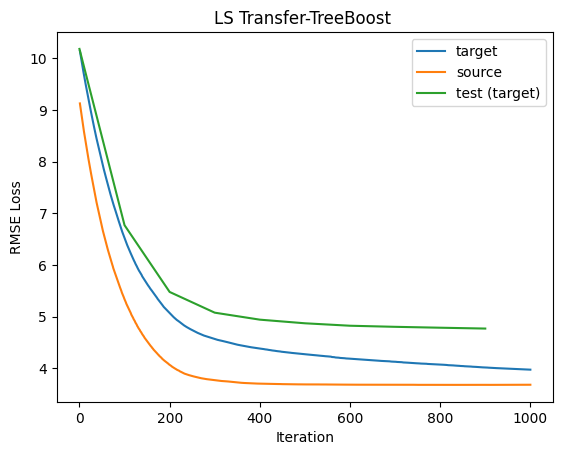

3.971264012054458

In [11]:
def LSTreeBoost(a, b, ahat, bhat, x_test, y_test, v1, v2, epochs=100, eval = True):
    """LS TreeBoost with proper indexing for different domain sizes but a single function estimate F."""

    # Concatenate all unique data points
    all_X = np.concatenate((a, ahat))  # Combine target and source features
    F = np.full(all_X.shape[0], np.mean(b))  # Initialize single function estimate
    F_source = np.full(all_X.shape[0], np.mean(bhat))
    all_y = np.concatenate((b, bhat))
    #F_source = F
    # Track trees and rho values
    model_tray_clf = []
    model_tray_clfhat = []
    leaf_gammas_tray = []
    leaf_gammashats_tray = []
    losses_target = []
    losses_source = []
    alpha_tray = []
    beta_tray = []
    alpha = 1.0
    losses_test = []
    epochs_test = []
    # Indices for each dataset within the combined set
    target_indices = np.arange(len(b))
    source_indices = np.arange(len(b), len(b)+len(bhat))
    all_indices = np.hstack([target_indices, source_indices])
    for m in range(epochs):
        # Compute residuals for the corresponding subsets
        b_residuals = b - F[target_indices]
        bhat_residuals = bhat - F[source_indices]
        b_residuals_all = all_y - F
        #b_residuals_all[source_indices] = bhat_residuals
        # Train decision trees on both target and source residuals
        clf = DecisionTreeRegressor(max_depth=2, min_samples_leaf=25)
        clf.fit(a, b_residuals)

        clfhat = DecisionTreeRegressor(max_depth=2, min_samples_leaf=25)
        clfhat.fit(ahat, bhat_residuals)
        
        model_tray_clf.append(clf)
        model_tray_clfhat.append(clfhat)
        
        # Get leaf indices for **both train and test**
        leaves_clf_target = clf.apply(a)
        leaves_clfhat_target = clfhat.apply(a)
        
        leaves_clf_source = clf.apply(ahat)
        leaves_clfhat_source = clfhat.apply(ahat)

        # Combine leaves from train and test for consistent indexing
        all_leaves_clf = np.concatenate([leaves_clf_target, leaves_clf_source])
        all_leaves_clfhat = np.concatenate([leaves_clfhat_target, leaves_clfhat_source])
        
        unique_leaves_clf = np.unique(all_leaves_clf)
        unique_leaves_clfhat = np.unique(all_leaves_clfhat)
        indexed_leaves_clf = map_leaves_to_number(leaves_clf_target)
        indexed_leaves_clfhat = map_leaves_to_number(leaves_clfhat_target)
       # print(f"Epoch {m}: unique_leaves_clfhat size = {len(unique_leaves_clfhat)}")
        #print(f"Epoch {m}: unique_leaves_clf size = {len(unique_leaves_clf)}")

        # Compute R matrix
        R = np.zeros((len(unique_leaves_clf), len(unique_leaves_clf)))
        for leaf_clf in indexed_leaves_clf:
            R[leaf_clf, leaf_clf] += 1

        # Compute Rhat matrix with decay on source elements
        Rhat = np.zeros((len(unique_leaves_clfhat), len(unique_leaves_clfhat)))
        for leaf_clfhat in indexed_leaves_clfhat:
            Rhat[leaf_clfhat, leaf_clfhat] += 1  # Apply decay to source dataset

        # Compute Intersection matrix N
        N = np.zeros((len(unique_leaves_clf), len(unique_leaves_clfhat)))
        for leaf_clf, leaf_clfhat in zip(indexed_leaves_clf, indexed_leaves_clfhat):
            N[leaf_clf, leaf_clfhat] += 1  # Scale source-related interactions

        # Construct Block Matrix M
        upper = np.hstack((R**2, N))
        lower = np.hstack((N.T, Rhat**2))
        M = np.vstack((upper, lower))

        ### Build the residual vector r ###
        r1 = np.zeros(len(unique_leaves_clf))
        r2 = np.zeros(len(unique_leaves_clfhat))
        for index in sorted(np.unique(indexed_leaves_clf)):
            indixes = np.where(indexed_leaves_clf == index)[0]
            r1[index] = np.sum(b_residuals[indixes])
        for index in sorted(np.unique(indexed_leaves_clfhat)):
            indixes = np.where(indexed_leaves_clfhat == index)[0]
            r2[index] = np.sum(b_residuals[indixes])
        r = np.concatenate((r1,r2))

        #print(f"Epoch {m}: r size = {len(r)}")
        #print(r)
        #print(f'residual vector: {r}')
        ### Solve to find gamma vector ###
        gamma_vector = np.linalg.lstsq(M, r, rcond = None)[0]
        #gamma_vector = np.sign(r)*0.03
        #gamma_vector+=np.random.uniform(-0.13,0.13,size=len(gamma_vector))
        #gamma_vector = np.linalg.solve(M, r) #for exact solution
        #print(f'gamma_vector: {gamma_vector}')
        #extract gamma and gammahat separately
        leaf_gamma = gamma_vector[:len(unique_leaves_clf)] 
        leaf_gammahat = gamma_vector[len(unique_leaves_clf):] 
        #print(f'gammas: {len(leaf_gammahat)}')
        
        #print(f'gamma hats: {leaf_gammahat}')
        #append to lists
        leaf_gammas_tray.append(leaf_gamma)
        leaf_gammashats_tray.append(leaf_gammahat)
        
        beta = 0
        #alpha, beta = compute_alpha_beta(b_residuals, clf.predict(a), clfhat.predict(a)) 
        #beta = max(0.02, beta)
        alpha = compute_alpha(b_residuals, clf.predict(a), clfhat.predict(a))
        #alpha = p(m)
        #alpha *= 0.995
        #alpha = max(0.02,alpha)
        alpha_tray.append(alpha)
        beta_tray.append(beta)
        
        indexed_leaves_clf = map_leaves_to_number(all_leaves_clf)
        indexed_leaves_clfhat = map_leaves_to_number(all_leaves_clfhat)
        #get averages for all leaves
        #print(len(leaf_gammahat))
        #print(np.unique(indexed_leaves_clfhat))
        #print(len(np.unique(indexed_leaves_clfhat)))
        #print(len(leaf_map_clfhat)) 
        for index in np.unique(indexed_leaves_clf):
            #print(len(F[np.where(indexed_leaves_clf == leaf)[0]]))
            F[indexed_leaves_clf == index] += v1*leaf_gamma[index]#*(1-alpha)
            #F_target[indexed_leaves_clf == index] += v*leaf_gamma[index]
        for index in np.unique(indexed_leaves_clfhat):
            #print(len(F[np.where(indexed_leaves_clf == leaf)[0]]))
            F[indexed_leaves_clfhat == index] += v2*leaf_gammahat[index]*alpha
            F_source[indexed_leaves_clfhat == index] += v2*leaf_gammahat[index]
            #F_source[indexed_leaves_clfhat == index] += v2*leaf_gammahat[index]

        
        # Compute RMSE loss on target domain
        mse_target = compute_rmse(F[target_indices], b)
        mse_source = compute_rmse(F[source_indices], bhat)
        
        #Evaluate on test set
        if m % 100 == 0:
            if eval:
                preds = boosted_prediction(x_test, a, b, model_tray_clf, model_tray_clfhat, 
                               leaf_gammas_tray, leaf_gammashats_tray, v1, v2, alpha_tray, beta_tray)
                mse_test = compute_rmse(preds, y_test)
                losses_test.append(mse_test)
                epochs_test.append(m)
        
        losses_target.append(mse_target)
        losses_source.append(mse_source)
        if m % 100 == 0:
            print(f'epoch: {m}')
            print(f'alpha: {alpha}')
            print(f'beta: {beta}')
            print(f'rmse: {mse_target}')
        #print(v2)
        

        

    return losses_target, losses_source, losses_test, epochs_test, leaf_gammas_tray, leaf_gammashats_tray, model_tray_clf, model_tray_clfhat, alpha_tray, beta_tray



# Train the model
epochs = 1000
v1=1.0
v2=1.0


losses_target, losses_source, losses_test, epochs_test, leaf_gammas_tray, leaf_gammashats_tray, model_tray_clf, model_tray_clfhat, alpha_tray, beta_tray = LSTreeBoost(a_train, b_train, 
                                                                                                                      ahat_train, bhat_train, x_test, y_test, 
                                                                                                                      v1=v1, v2=v2,
                                                                                                                      epochs=epochs)
# Test the model
#final_predictions = boosted_prediction(x_test, b_train, model_tray, rho_values, alpha_0=alpha_0, alpha_decay = alpha_decay)

# Plot loss curve
plt.plot(range(1, len(losses_target) + 1), losses_target)
plt.plot(range(1, len(losses_source) + 1), losses_source)
plt.plot(epochs_test, losses_test)
plt.xlabel("Iteration")
plt.ylabel("RMSE Loss")
plt.title("LS Transfer-TreeBoost ")
plt.legend(['target', 'source', 'test (target)'])
plt.show()

losses_target[-1]

In [12]:
preds = boosted_prediction(x_test, a_train, b_train, 
                           model_tray_clf, model_tray_clfhat, 
                           leaf_gammas_tray, leaf_gammashats_tray,
                           v1=v1, v2=v2, alpha_tray=alpha_tray, beta_tray = beta_tray)
compute_rmse(preds, y_test)

4.755592258934925

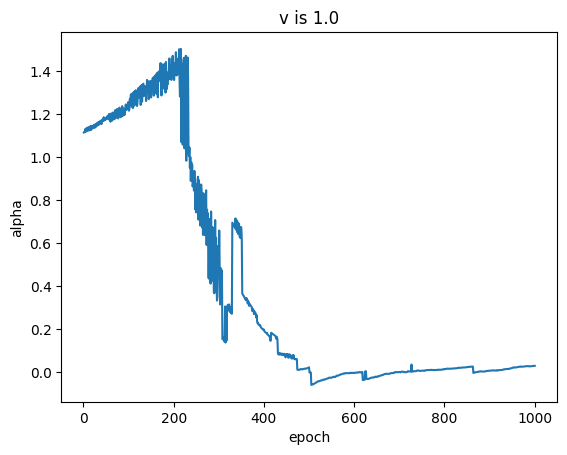

In [13]:
# Plot loss curve
plt.plot(range(1, len(losses_target) + 1), alpha_tray)
plt.title(f'v is {v1}')
plt.xlabel('epoch')
plt.ylabel('alpha')

plt.show()